In [14]:
import numpy as np
import pandas as pd
from math import isclose
from matplotlib import pyplot as plt
from scipy.sparse import hstack, vstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from typing import Union, List

In [2]:
def write_to_submission_file(predicted_probs, out_file: str = 'to_submission.csv',
                             target='target', index_label='session_id'):
    df = pd.DataFrame(predicted_probs,
                      index = np.arange(1, len(predicted_probs) + 1),
                      columns=[target])
    df.to_csv(out_file, index_label=index_label)

In [3]:
"""Define all type transformations in a single function"""
def convert_types(df: pd.DataFrame) -> pd.DataFrame:
    sites = [s for s in df.columns if "site" in s]
    df[sites] = df[sites].fillna(0).astype('uint16')
    times = [t for t in df.columns if "time" in t]
    df[times] = df[times].apply(pd.to_datetime)
    if 'target' in df.columns:
        df['target'] = df.target.astype('uint8')
    return df

In [4]:
import os
# os.getcwd()
# os.listdir("../../../../")

train_df = pd.read_csv('../../../../data/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/train_sessions.csv.zip')
train_df = convert_types(train_df)
train_df.sort_values(by='time1', inplace=True)

test_df = pd.read_csv('../../../../data/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/test_sessions.csv.zip')
test_df = convert_types(test_df)

In [5]:
sites = [s for s in train_df.columns if 'site' in s]
times = [t for t in train_df.columns if 'time' in t]

sites, times

(['site1',
  'site2',
  'site3',
  'site4',
  'site5',
  'site6',
  'site7',
  'site8',
  'site9',
  'site10'],
 ['time1',
  'time2',
  'time3',
  'time4',
  'time5',
  'time6',
  'time7',
  'time8',
  'time9',
  'time10'])

In [6]:
# Our target variable
y_train = train_df["target"]

# United dataframe of the initial data
full_df = pd.concat([train_df.drop("target", axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [7]:
%%time
sites_corpus = full_df[sites].to_string(header=False, index=False).split('\n')

sites_corpus[:10]

Wall time: 8.18 s


['   56    55     0     0     0     0     0     0     0     0',
 '   56    55    56    55     0     0     0     0     0     0',
 '  946   946   951   946   946   945   948   784   949   946',
 '  945   948   949   948   945   946   947   945   946   946',
 '  947   950   948   947   950   952   946   951   946   947',
 '  952   947   953   946   947   946   953   955   946   947',
 '  953   947   946   953   955   947   953   946   953  1033',
 '  946   947   954   953   946   954   946   956   957   956',
 '  946   956   946   946   955   954   946   946   946   948',
 '  948   946   948   784    49    53   812   982    52    52']

In [8]:
%%time
# tfv = TfidfVectorizer(ngram_range=(1,5), max_features=100000) # TODO optimize ngram_range and max_features
tfv = TfidfVectorizer()
X_train = tfv.fit_transform(sites_corpus[:idx_split])
X_test = tfv.transform(sites_corpus[idx_split:])

X_full = vstack([X_train, X_test]).tocsr()
X_full

Wall time: 4.19 s


<336358x41592 sparse matrix of type '<class 'numpy.float64'>'
	with 1818178 stored elements in Compressed Sparse Row format>

In [9]:
def get_auc_logit_score(X, y, C=1.0, seed=17, n_splits=10):
    # Split the data into the training and validation sets
    time_split = TimeSeriesSplit(n_splits=n_splits)
    logit = LogisticRegression(C=1, random_state=17, solver='liblinear')
    cv_scores = cross_val_score(logit, X, y, cv=time_split, scoring='roc_auc', n_jobs=-1)
    return cv_scores.mean()

In [10]:
%%time
get_auc_logit_score(X_train, y_train)

Wall time: 7.7 s


0.863111282374818

In [19]:
# n_gram range for fixed_maxfeatures

max_n_grams = 10
max_feat=50000
n_gram_range = [(1, x) for x in range(1, max_n_grams + 1)]
scores = []
for n_gram in n_gram_range:
    tfv = TfidfVectorizer(ngram_range=n_gram, max_features=max_feat)
    print(f"Testing n_gram {n_gram}")
    %time X_train = tfv.fit_transform(sites_corpus[:idx_split])    
    %time score = get_auc_logit_score(X_train, y_train)
    scores.append(score)
    print(score)

Testing n_gram (1, 1)
Wall time: 2.77 s
Wall time: 3.29 s
0.863111282374818
Testing n_gram (1, 2)
Wall time: 6.09 s
Wall time: 4.49 s
0.86572433579339
Testing n_gram (1, 3)
Wall time: 12.2 s
Wall time: 5.54 s
0.8670511389880462
Testing n_gram (1, 4)
Wall time: 15.3 s
Wall time: 5.11 s
0.8668274209992417
Testing n_gram (1, 5)
Wall time: 20 s
Wall time: 5.59 s
0.8679579071948579
Testing n_gram (1, 6)
Wall time: 25.7 s
Wall time: 5.41 s
0.8679004156228467
Testing n_gram (1, 7)
Wall time: 27.7 s
Wall time: 5.46 s
0.8677899000540152
Testing n_gram (1, 8)
Wall time: 30.6 s
Wall time: 5.55 s
0.8677830181588959
Testing n_gram (1, 9)
Wall time: 30.8 s
Wall time: 5.59 s
0.8681763348362163
Testing n_gram (1, 10)
Wall time: 32.6 s
Wall time: 5.27 s
0.868079339817684


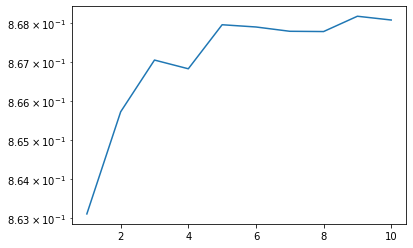

In [24]:
plt.plot(range(1, max_n_grams + 1), scores)
plt.yscale('log')

In [12]:
# max_feat reange for fixed n_grams
n_gram = (1, 5)

max_feat_range = np.linspace(1e4, 1e6, 10).astype(int)

scores = []

for max_feat in max_feat_range:
    tfv = TfidfVectorizer(ngram_range=n_gram, max_features=max_feat)
    print(f"Testing max_feat {max_feat}")
    %time X_train = tfv.fit_transform(sites_corpus[:idx_split])    
    %time score = get_auc_logit_score(X_train, y_train)
    scores.append(score)
    print(score)

Testing max_feat 10000
Wall time: 20.4 s
Wall time: 4.3 s
0.8618739442053389
Testing max_feat 120000
Wall time: 19.5 s
Wall time: 8.64 s
0.8645819886666486
Testing max_feat 230000
Wall time: 22.3 s
Wall time: 14 s
0.8619296346931057
Testing max_feat 340000
Wall time: 19.8 s
Wall time: 14.8 s
0.8604235731148794
Testing max_feat 450000
Wall time: 20.1 s
Wall time: 18.6 s
0.8592910974169318
Testing max_feat 560000
Wall time: 20.8 s
Wall time: 19.2 s
0.8591141139835254
Testing max_feat 670000
Wall time: 20.5 s
Wall time: 21.6 s
0.8583660664728432
Testing max_feat 780000
Wall time: 20.6 s
Wall time: 23.4 s
0.8580768339572306
Testing max_feat 890000
Wall time: 22.3 s
Wall time: 23.7 s
0.8577592173551578
Testing max_feat 1000000
Wall time: 20.6 s
Wall time: 26.6 s
0.8564393383992362


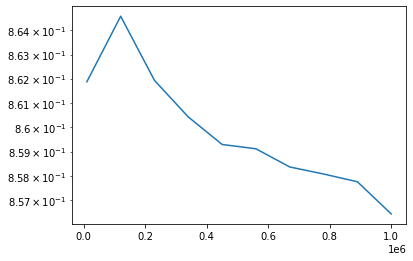

In [16]:
plt.plot(max_feat_range, scores)
plt.yscale('log')

Testing max_feat 1000
Wall time: 20.8 s
Wall time: 3.09 s
0.8482857951575934
Testing max_feat 23111
Wall time: 22.6 s
Wall time: 4.73 s
0.8661891151621687
Testing max_feat 45222
Wall time: 20.7 s
Wall time: 5.32 s
0.8681146867772161
Testing max_feat 67333
Wall time: 22 s
Wall time: 6.05 s
0.8669399245700161
Testing max_feat 89444
Wall time: 20.9 s
Wall time: 7.91 s
0.8645343380047464
Testing max_feat 111555
Wall time: 21.8 s
Wall time: 7.51 s
0.8647338658574443
Testing max_feat 133666
Wall time: 20.6 s
Wall time: 9.22 s
0.8640291210824627
Testing max_feat 155777
Wall time: 21.2 s
Wall time: 10.5 s
0.8634364730363009
Testing max_feat 177888
Wall time: 19.7 s
Wall time: 10.7 s
0.8633324020414264
Testing max_feat 200000
Wall time: 20.6 s
Wall time: 11.2 s
0.8625892234139284


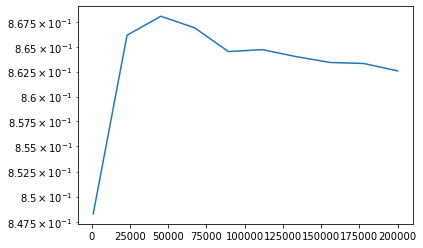

In [17]:
# fine tuning max_features and n_gram
# max_feat reange for fixed n_grams
n_gram = (1, 5)

max_feat_range = np.linspace(1e3, 2*1e5, 10).astype(int)

scores = []

for max_feat in max_feat_range:
    tfv = TfidfVectorizer(ngram_range=n_gram, max_features=max_feat)
    print(f"Testing max_feat {max_feat}")
    %time X_train = tfv.fit_transform(sites_corpus[:idx_split])
    %time score = get_auc_logit_score(X_train, y_train)
    scores.append(score)
    print(score)
    
plt.plot(max_feat_range, scores)
plt.yscale('log')

In [94]:
# It seems optimal max_featurs range is close to the total number of words (~45k)
# grid search for optimal max_feat and n_gram

# n_gram_range = [(1, x) for x in range(2, 10)]
# max_feat_range = np.linspace(2e4, 6e4, 10).astype(int)


n_gram_range = [(1, x) for x in range(1, 10)]
max_feat_range = np.linspace(2e4, 6e4, 10).astype(int)


scores_2d = np.empty((len(n_gram_range), len(max_feat_range)))

for i, n_gram in enumerate(n_gram_range):
    for j, max_feat in enumerate(max_feat_range):
            print(f"{i* scores_2d.shape[0] + (j + 1)} / {scores_2d.size}")
#             print(f"i:{i} j: {j}")
#             scores_2d[i, j] = 0
            tfv = TfidfVectorizer(ngram_range=n_gram, max_features=max_feat)
            %time X_train = tfv.fit_transform(sites_corpus[:idx_split])
            %time scores_2d[i, j] = get_auc_logit_score(X_train, y_train)                    

1 / 90
Wall time: 3.19 s
Wall time: 6.82 s
2 / 90
Wall time: 2.94 s
Wall time: 3.49 s
3 / 90
Wall time: 3.39 s
Wall time: 3.4 s
4 / 90
Wall time: 3.22 s
Wall time: 3.54 s
5 / 90
Wall time: 3.14 s
Wall time: 3.46 s
6 / 90
Wall time: 3.16 s
Wall time: 3.77 s
7 / 90
Wall time: 3.16 s
Wall time: 3.79 s
8 / 90
Wall time: 3.21 s
Wall time: 4.34 s
9 / 90
Wall time: 3.68 s
Wall time: 4.55 s
10 / 90
Wall time: 5.23 s
Wall time: 3.59 s
10 / 90
Wall time: 7.23 s
Wall time: 4.36 s
11 / 90
Wall time: 7.1 s
Wall time: 4.61 s
12 / 90
Wall time: 7.09 s
Wall time: 4.27 s
13 / 90
Wall time: 9.4 s
Wall time: 5.77 s
14 / 90
Wall time: 10.3 s
Wall time: 4.95 s
15 / 90
Wall time: 7.26 s
Wall time: 4.84 s
16 / 90
Wall time: 6.38 s
Wall time: 4.43 s
17 / 90
Wall time: 8.73 s
Wall time: 6.96 s
18 / 90
Wall time: 6.96 s
Wall time: 5.29 s
19 / 90
Wall time: 7.38 s
Wall time: 5.36 s
19 / 90
Wall time: 11.6 s
Wall time: 4.31 s
20 / 90
Wall time: 13.1 s
Wall time: 4.06 s
21 / 90
Wall time: 10.5 s
Wall time: 5.34 s


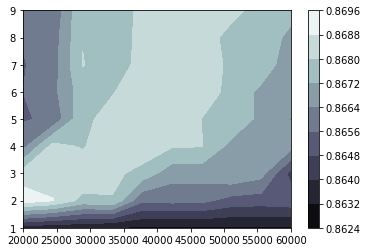

(array([20000, 24444, 28888, 33333, 37777, 42222, 46666, 51111, 55555,
        60000]),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 (9, 10))

In [95]:
y = np.array([x[1] for x in n_gram_range])
x = max_feat_range
z = scores_2d

contourplot = plt.contourf(x, y, z, cmap=plt.cm.bone, origin='lower')
cbar = plt.colorbar(contourplot)
plt.show()

In [106]:
# refined search
n_gram_range = [(1, x) for x in range(1, 5)]
max_feat_range = np.linspace(1e3, 3e4, 10).astype(int)


scores_2d = np.empty((len(n_gram_range), len(max_feat_range)))

for i, n_gram in enumerate(n_gram_range):
    for j, max_feat in enumerate(max_feat_range):
            print(f"{i* scores_2d.shape[0] + (j + 1)} / {scores_2d.size}")
#             print(f"i:{i} j: {j}")
#             scores_2d[i, j] = 0
            tfv = TfidfVectorizer(ngram_range=n_gram, max_features=max_feat)
            %time X_train = tfv.fit_transform(sites_corpus[:idx_split])
            %time scores_2d[i, j] = get_auc_logit_score(X_train, y_train)   

1 / 40
Wall time: 2.93 s
Wall time: 6.6 s
2 / 40
Wall time: 3.28 s
Wall time: 3.07 s
3 / 40
Wall time: 3.08 s
Wall time: 2.96 s
4 / 40
Wall time: 2.86 s
Wall time: 2.94 s
5 / 40
Wall time: 3.25 s
Wall time: 3.18 s
6 / 40
Wall time: 3.14 s
Wall time: 3.57 s
7 / 40
Wall time: 3.45 s
Wall time: 3.05 s
8 / 40
Wall time: 3.29 s
Wall time: 3.43 s
9 / 40
Wall time: 3.03 s
Wall time: 3.52 s
10 / 40
Wall time: 2.97 s
Wall time: 3.4 s
5 / 40
Wall time: 6.65 s
Wall time: 3.14 s
6 / 40
Wall time: 6.5 s
Wall time: 3.53 s
7 / 40
Wall time: 6.62 s
Wall time: 3.5 s
8 / 40
Wall time: 7.81 s
Wall time: 5.87 s
9 / 40
Wall time: 10.3 s
Wall time: 4.56 s
10 / 40
Wall time: 8.64 s
Wall time: 4.8 s
11 / 40
Wall time: 8.2 s
Wall time: 4.08 s
12 / 40
Wall time: 6.53 s
Wall time: 4.48 s
13 / 40
Wall time: 6.49 s
Wall time: 4.13 s
14 / 40
Wall time: 6.55 s
Wall time: 4.51 s
9 / 40
Wall time: 11.4 s
Wall time: 3.15 s
10 / 40
Wall time: 10.2 s
Wall time: 3.28 s
11 / 40
Wall time: 10.4 s
Wall time: 3.53 s
12 / 40
W

In [108]:
scores_2d

array([[0.85974245, 0.86405283, 0.86677453, 0.86521271, 0.86335048,
        0.86343611, 0.86336163, 0.86332281, 0.86332926, 0.86333327],
       [0.85273517, 0.8617104 , 0.86644056, 0.8664781 , 0.86825303,
        0.86919273, 0.8693971 , 0.86883463, 0.86747557, 0.86780564],
       [0.85084302, 0.86075204, 0.86161182, 0.86580019, 0.86596213,
        0.8664298 , 0.86832283, 0.86836132, 0.86864478, 0.86882683],
       [0.84867094, 0.86232209, 0.86160243, 0.86278963, 0.86631408,
        0.86577825, 0.8663212 , 0.86813594, 0.86793448, 0.8682258 ]])

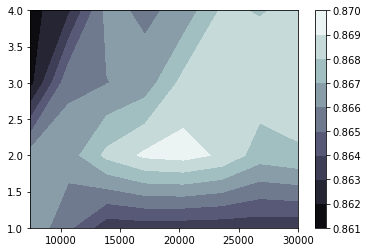

In [113]:
y = np.array([x[1] for x in n_gram_range])
x = max_feat_range[2:]
z = scores_2d[:, 2:]

contourplot = plt.contourf(x, y, z, cmap=plt.cm.bone, origin='lower')
cbar = plt.colorbar(contourplot)
plt.show()

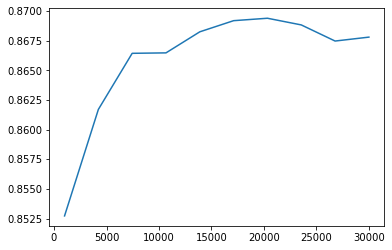

In [120]:
plt.plot(max_feat_range, scores_2d[1])

In [ ]:
# best features
n_gram = (1, 2)
max_features = 20000